# CNN Architectures
In this notebook we will explore standard CNN architectures using PyTorch and torchvision.

You can find more information on how to finetune pretrained models [here](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
# !pip install torchsummary
from torchsummary import summary

### CIFAR10 Dataset

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Since we are going to use pretrained CNNs (on ImageNet), we need to normalize our data 
# According to the mean and std with which these networks were trained, i.e. with the statistics of the ImageNet dataset
data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)
print(f"Training size: {len(training_data)} \nValidation size: {len(validation_data)}")

Files already downloaded and verified
Files already downloaded and verified
Training size: 50000 
Validation size: 10000


In [3]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


### Training loop

In [4]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [5]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # Save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # Save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # Save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [6]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### 7x7 versus 3x3 Convolutions

Historically, the VGG was the first CNN architecture to introduce more layers (16-19 layers versus the 8 layers of AlexNet) and smaller convolutional kernel sizes (3x3).

This is mainly due to the fact that a stack of 3 3x3 convolutional layers (with stride 1) has the same effective receptive field as a single 7x7 layer. Why?

You can find out more about the effective receptive field of CNNs and explore some visualizations [here](https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).

Compare the number of parameters of a single convolutional layer with 7x7 kernel with a stack of 3 convolutional layers with 3x3 kernels.

In [7]:
m1 = nn.Sequential(nn.Conv2d(1, 1, kernel_size=(7, 7), padding=0)).to(device)
summary(m1, (1, 32, 32))

m2 = nn.Sequential(nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0), 
                   nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0), 
                   nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0)).to(device)
summary(m2, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              50
Total params: 50
Trainable params: 50
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 30, 30]              10
            Conv2d-2            [-1, 1, 28, 28]              10
            Conv2d-3            [-1, 1, 26, 26]              10
Total params: 30
Trainable params: 30
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB

What are the advantages of using a stack of 3 convolutional layers with 3x3 kernels instead of a single 7x7 layer?

R: The use of smaller filters like 3x3 kernels lead to less computation, and allows us to learn large complex features easily, whereas large filters learn simple features. 

### VGG model

Finetune a VGG-16 model.




In [8]:
# Load model from torchvision (with pretrained=True)
vgg = models.vgg16(pretrained=True)
print(vgg)

# Change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg.classifier[6] = nn.Linear(4096, 10)

vgg.to(device)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Inspect the model structure.

What does the AdaptiveAvgPool2d layer do?

R: Applies a 2D adaptive average pooling over an input signal composed of several input planes.

What is the shape of the feature map before and after this layer?

R: The VGG model expects input images with size 224×224. Before the AdaptiveAvgPool2d layer, the feature map shape is [-1, 512, 14, 14]. After this layer, the feature map is reduced to [-1, 512, 7, 7].

Start training...

Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:23<00:00,  5.43it/s]


Train loss: 1.075 	 Train acc: 0.626


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.72it/s]


Val loss: 0.728 	 Val acc: 0.747

Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:29<00:00,  5.24it/s]


Train loss: 0.690 	 Train acc: 0.763


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.56it/s]


Val loss: 0.625 	 Val acc: 0.786

Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:31<00:00,  5.17it/s]


Train loss: 0.580 	 Train acc: 0.801


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.36it/s]


Val loss: 0.577 	 Val acc: 0.806

Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:32<00:00,  5.12it/s]


Train loss: 0.516 	 Train acc: 0.822


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.33it/s]


Val loss: 0.531 	 Val acc: 0.821

Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:32<00:00,  5.13it/s]


Train loss: 0.464 	 Train acc: 0.841


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.29it/s]


Val loss: 0.508 	 Val acc: 0.826

Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:32<00:00,  5.12it/s]


Train loss: 0.422 	 Train acc: 0.855


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.96it/s]


Val loss: 0.501 	 Val acc: 0.832

Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:34<00:00,  5.05it/s]


Train loss: 0.388 	 Train acc: 0.865


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.11it/s]


Val loss: 0.479 	 Val acc: 0.838

Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:33<00:00,  5.10it/s]


Train loss: 0.355 	 Train acc: 0.878


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.36it/s]


Val loss: 0.466 	 Val acc: 0.842

Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:32<00:00,  5.12it/s]


Train loss: 0.329 	 Train acc: 0.886


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.09it/s]


Val loss: 0.467 	 Val acc: 0.842

Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:33<00:00,  5.09it/s]


Train loss: 0.303 	 Train acc: 0.895


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.30it/s]


Val loss: 0.461 	 Val acc: 0.847
Finished


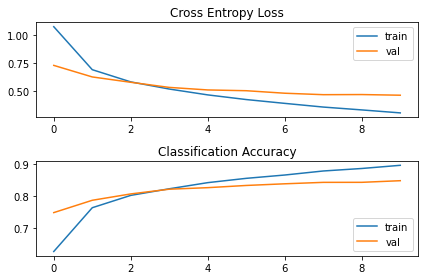

In [9]:
num_epochs = 10
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)

### ResNet Model
Repeat the finetuning process with a ResNet-50 model.

In [10]:
# Load model from torchvision (with pretrained=True)
resnet = models.resnet50(pretrained=True)

# Change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
resnet.fc = nn.Linear(2048, 10)

resnet.to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Start training...

Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:29<00:00,  8.73it/s]


Train loss: 1.732 	 Train acc: 0.406


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.10it/s]


Val loss: 1.232 	 Val acc: 0.586

Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:34<00:00,  8.29it/s]


Train loss: 1.067 	 Train acc: 0.631


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.84it/s]


Val loss: 0.947 	 Val acc: 0.674

Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:35<00:00,  8.20it/s]


Train loss: 0.850 	 Train acc: 0.707


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.63it/s]


Val loss: 0.817 	 Val acc: 0.721

Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:35<00:00,  8.18it/s]


Train loss: 0.722 	 Train acc: 0.749


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.60it/s]


Val loss: 0.749 	 Val acc: 0.738

Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:35<00:00,  8.17it/s]


Train loss: 0.626 	 Train acc: 0.784


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.87it/s]


Val loss: 0.709 	 Val acc: 0.756

Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:35<00:00,  8.15it/s]


Train loss: 0.553 	 Train acc: 0.811


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.73it/s]


Val loss: 0.685 	 Val acc: 0.761

Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:35<00:00,  8.15it/s]


Train loss: 0.492 	 Train acc: 0.831


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.46it/s]


Val loss: 0.673 	 Val acc: 0.765

Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:36<00:00,  8.08it/s]


Train loss: 0.430 	 Train acc: 0.852


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.68it/s]


Val loss: 0.667 	 Val acc: 0.772

Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:35<00:00,  8.15it/s]


Train loss: 0.377 	 Train acc: 0.872


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.64it/s]


Val loss: 0.663 	 Val acc: 0.778

Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:37<00:00,  8.04it/s]


Train loss: 0.327 	 Train acc: 0.890


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.73it/s]


Val loss: 0.674 	 Val acc: 0.779
Finished


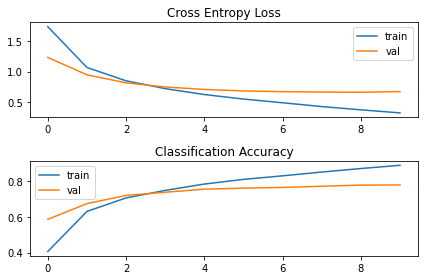

In [11]:
num_epochs = 10
model_name = 'resnet50'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_resnet)

plotTrainingHistory(resnet_train_history, resnet_val_history)

### Compare the VGG and ResNet models in terms of:

1.   number of parameters
2.   validation accuracy
3.   training time

R: VGG has a lot more parameters than ResNet (134,3M vs 23,5M), higher validation accuracy than ResNet (0.847 vs 0.779), and takes more training time than ResNet(2,5 min vs 1,5 min).

What is the main difference introduced by the ResNet architecture?

R: The core idea of ResNet is introducing a so-called "identity shortcut connection" that skips one or more layers. In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Network. In this network we use a technique called skip connections. The skip connection skips training from a few layers and connects directly to the output. The advantage of adding this type of skip connection is because if any layer hurt the performance of architecture then it will be skipped by regularization. So, this results in training very deep neural network without the problems caused by vanishing/exploding gradient.

In [12]:
summary(vgg, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [13]:
summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25